## Install Libraries

In [1]:
import os
os.system("pip install convertdate==2.2.1 pystan==2.19.1.1 fbprophet==0.6")
os.system("pip install slack")
os.system("pip install slackclient")
os.system("pip install yfinance")
os.system("pip install yahoofinancials")
os.system("pip install statsmodels")
os.system("pip install sklearn")

## Import Packages

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
plt.style.use('fivethirtyeight')

import yfinance as yf
from yahoofinancials import YahooFinancials
import statistics
from statistics import stdev

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from numpy import log
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet import Prophet
from datetime import date
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from matplotlib import pyplot

from typing import  List
from datetime import datetime
from io import StringIO
import joblib
from minio import Minio
from subprocess import run, Popen, PIPE

import joblib

Importing plotly failed. Interactive plots will not work.


## Pipeline Parameters
- period : Number of years of historic data to be collected from yahoo finance to train the model
- path : path where you want to store the results and model
- ticker : The ticker to which you want to predict the stock price. Name of the ticker can be found here https://www.nasdaq.com/market-activity/stocks/screener 

Note : You can predict stock for any ticker only if model is trained for that ticker. So if you want to predict for any new ticker, run modelling pipeline for that ticker

In [3]:
period='2y'
path = "/kfs_private/yahoo_stock/"
ticker = 'TSLA'

## Load Data
- Load data from yahoo finance for the given ticker for a period of time

In [4]:
df = yf.download(ticker, period=period).reset_index()
df.head()

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2020-01-21,106.050003,109.716003,105.681999,109.440002,109.440002,89017500
1,2020-01-22,114.377998,118.900002,111.820000,113.912003,113.912003,156845000
2,2020-01-23,112.849998,116.400002,111.120003,114.440002,114.440002,98255000
3,2020-01-24,114.125999,114.772003,110.851997,112.963997,112.963997,71768000
4,2020-01-27,108.398003,112.888000,107.856003,111.603996,111.603996,68040500


In [5]:
df.shape

(504, 7)

In [6]:
len(df['Date'].unique())

504

## Data Statistics

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 504 entries, 0 to 503
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       504 non-null    datetime64[ns]
 1   Open       504 non-null    float64       
 2   High       504 non-null    float64       
 3   Low        504 non-null    float64       
 4   Close      504 non-null    float64       
 5   Adj Close  504 non-null    float64       
 6   Volume     504 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 27.7 KB


In [8]:
df.dtypes

Date         datetime64[ns]
Open                float64
High                float64
Low                 float64
Close               float64
Adj Close           float64
Volume                int64
dtype: object

## Exploratory Data Analysis

In [9]:
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [10]:
df.Date=pd.to_datetime(df['Date'])

In [11]:
df.Date.min(),df.Date.max()

(Timestamp('2020-01-21 00:00:00'), Timestamp('2022-01-18 00:00:00'))

In [12]:
df.Date.max()-df.Date.min()

Timedelta('728 days 00:00:00')

In [13]:
df.set_index('Date',inplace=True)

In [14]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-21,106.050003,109.716003,105.681999,109.440002,109.440002,89017500
2020-01-22,114.377998,118.900002,111.820000,113.912003,113.912003,156845000
2020-01-23,112.849998,116.400002,111.120003,114.440002,114.440002,98255000
2020-01-24,114.125999,114.772003,110.851997,112.963997,112.963997,71768000
2020-01-27,108.398003,112.888000,107.856003,111.603996,111.603996,68040500


<AxesSubplot:xlabel='Date'>

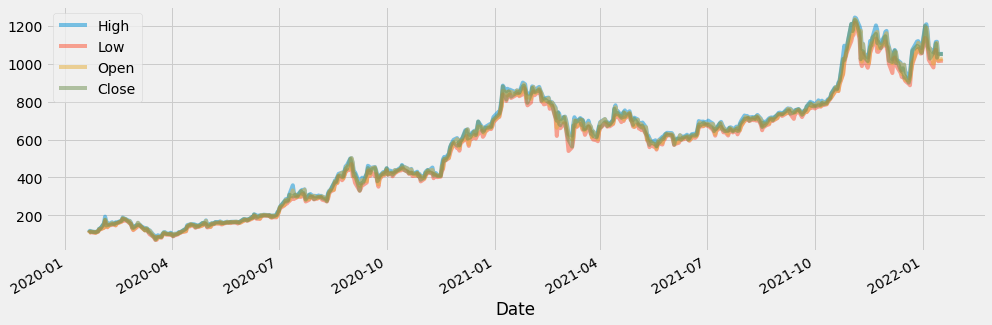

In [15]:
df[['High','Low','Open','Close']].plot(figsize = (15, 5), alpha = 0.5)

## Evaluating Stationarity

<AxesSubplot:>

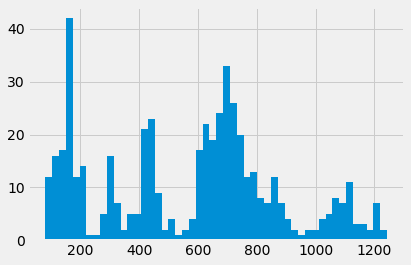

In [16]:
df.High.hist(bins=50)

In [17]:
sh = int(np.round(df.shape[0]/10,0))
sh

50

In [18]:
mean=[]
std=[]
    
for i in range(0,10):
    mean.append(df['High'].iloc[(i*sh):(i*sh)+sh].mean())
    std.append(stdev(df['High'].iloc[(i*sh):(i*sh)+sh]))

In [19]:
pd.concat([pd.DataFrame(mean,columns=['mean']),pd.DataFrame(std,columns=['std'])], axis=1)

,mean,std
0,136.134360,29.622994
1,156.688440,24.657778
2,286.431481,60.681340
3,433.964761,27.020396
4,615.469999,134.823121
5,767.184001,87.891798
6,668.649194,57.278801
7,675.686803,34.359768
8,808.731595,104.121651
9,1099.768394,80.523632


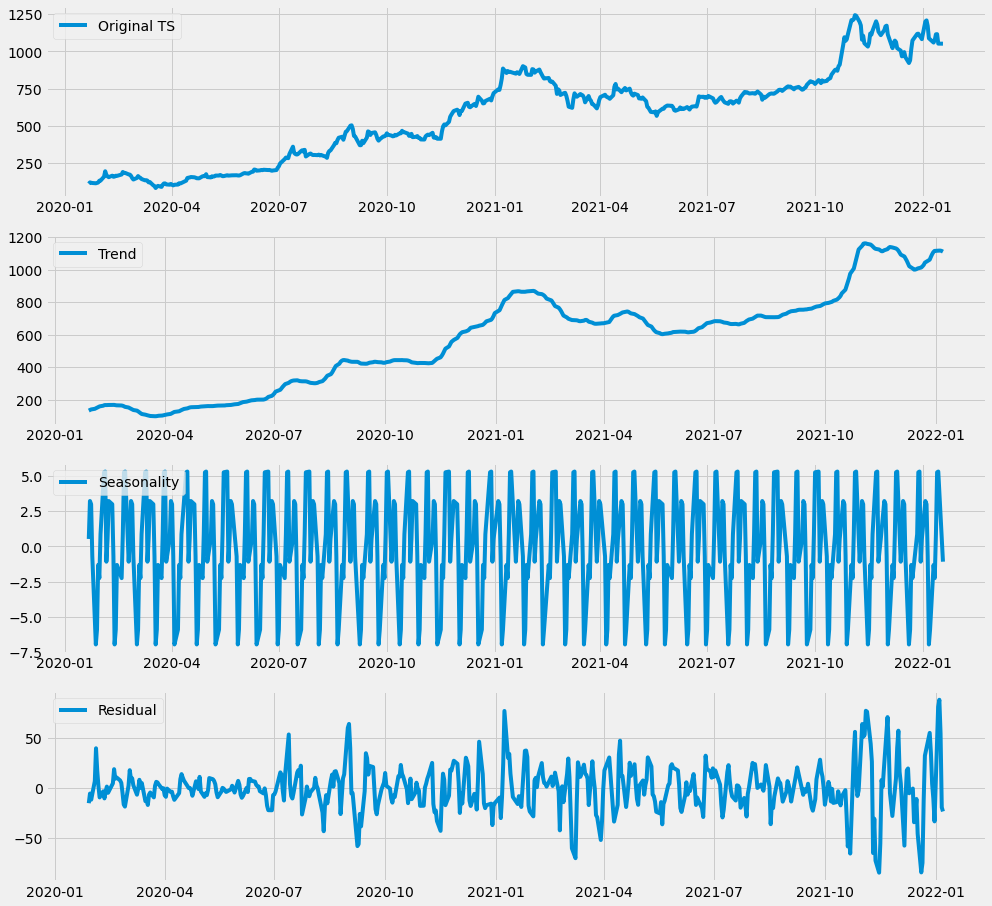

In [20]:
decompose_add=seasonal_decompose(df['High'], model='additive', period=12)
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(df['High'], label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_add.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_add.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_add.resid, label='Residual')
plt.legend(loc='best')

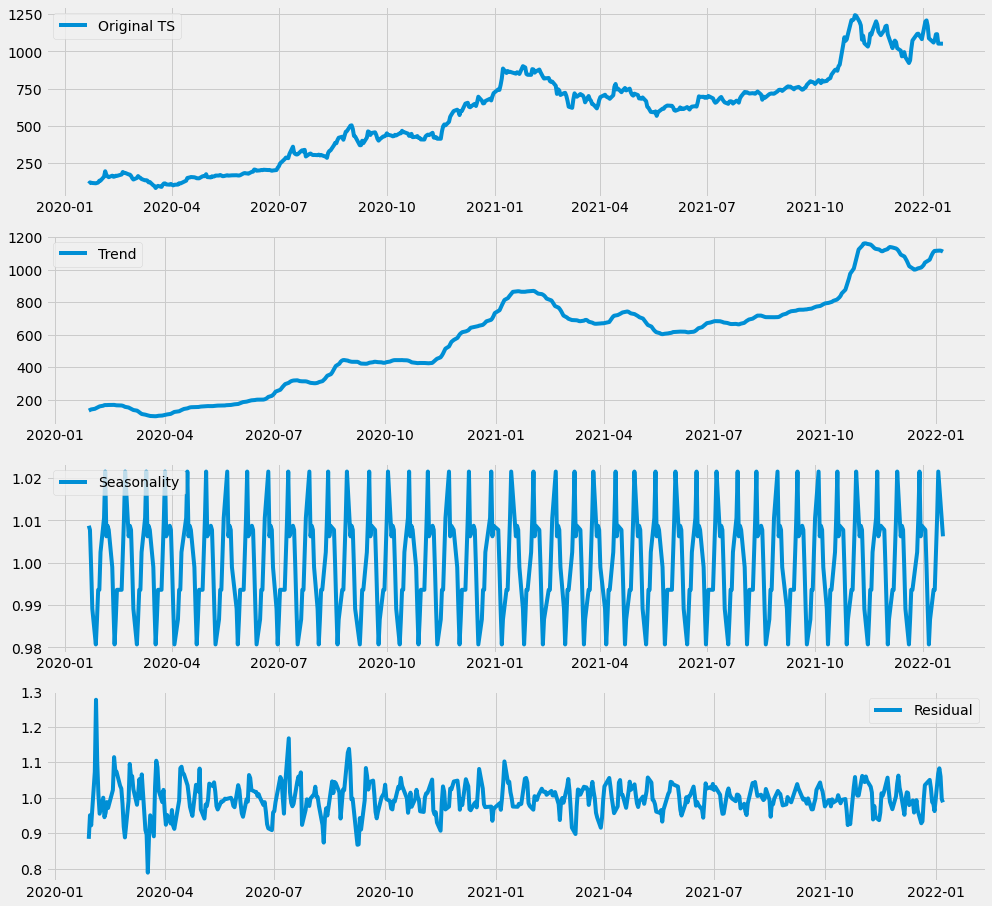

In [21]:
decompose_mul=seasonal_decompose(df['High'], model='multiplicative', period=12)
plt.figure(figsize=(15,15))
plt.subplot(411)
plt.plot(df['High'], label='Original TS')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(decompose_mul.trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(decompose_mul.seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(decompose_mul.resid, label='Residual')
plt.legend(loc='best')

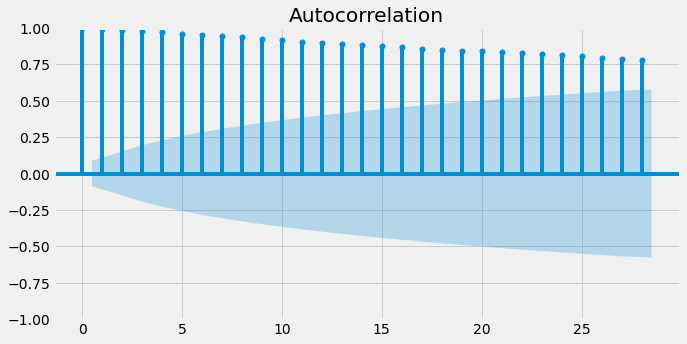

In [22]:
plt.rc("figure", figsize=(10,5))
plot_acf(df['High'])
print()

/opt/conda/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


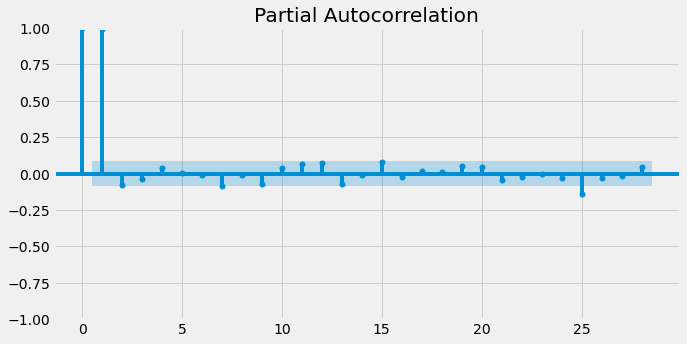

In [23]:
plt.rc("figure", figsize=(10,5))
plot_pacf(df['High'])
print()

In [24]:
result = adfuller(df['High'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -0.934112
p-value: 0.776531
Critical Values:
	1%: -3.444
	5%: -2.867
	10%: -2.570


In [25]:

result = adfuller(log(df['High']))
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: -1.564441
p-value: 0.501427
Critical Values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [26]:
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-21,106.050003,109.716003,105.681999,109.440002,109.440002,89017500
2020-01-22,114.377998,118.900002,111.820000,113.912003,113.912003,156845000
2020-01-23,112.849998,116.400002,111.120003,114.440002,114.440002,98255000
2020-01-24,114.125999,114.772003,110.851997,112.963997,112.963997,71768000
2020-01-27,108.398003,112.888000,107.856003,111.603996,111.603996,68040500
...,...,...,...,...,...,...
2022-01-11,1053.670044,1075.849976,1038.819946,1064.400024,1064.400024,22021100
2022-01-12,1078.849976,1114.839966,1072.589966,1106.219971,1106.219971,27913000
2022-01-13,1109.069946,1115.599976,1026.540039,1031.560059,1031.560059,32403300


In [27]:
new_df=df['High'].iloc[:-4]

## Split train and test Data
- Taken three months of data for test and test data is treated as training data

In [28]:
df=df.reset_index()[['Date','High']].rename({'Date':'ds','High':'y'},axis='columns')

In [29]:
train=df[df['ds'] <= (df['ds'].max() - pd.DateOffset(months=3))]
test=df[df['ds'] > (df['ds'].max() - pd.DateOffset(months=3))]

In [30]:
MODEL_NAME = "yahoo_stock_model_"+ticker

## Prophet Model Training
- Initialize facebook prophet model and train different model for a ticker

In [31]:
model=Prophet()
model.fit(train)

test_pred = model.predict(test[['ds']])

print("r2_score : ", r2_score(test['y'],test_pred['yhat']))
print("mean_absolute_error : ", mean_absolute_error(test['y'],test_pred['yhat']))

print("root_mean_squared_error : ", np.sqrt(mean_squared_error(test['y'],test_pred['yhat'])))
    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.1824
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       934.884     0.0184704        143.64      0.7311      0.7311      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       950.427      0.026806        203.01       0.581           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       953.428    0.00235893       225.987     2.1e-05       0.001      338  LS failed, Hessian reset 
     299       956.224   0.000209942       69.5508      0.2652           1      410   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     316       956.725   0.000715013       174.672   5.647e-06       0.001      466  LS failed, Hessian reset 
     399       957.188   2.21385e-06       79.0579      0.8103      0.8103      583   
    Iter      log prob

In [32]:
joblib.dump(model,path+MODEL_NAME+".joblib")

['/kfs_private/yahoo_stock/yahoo_stock_model_TSLA.joblib']

## Model Evaluation

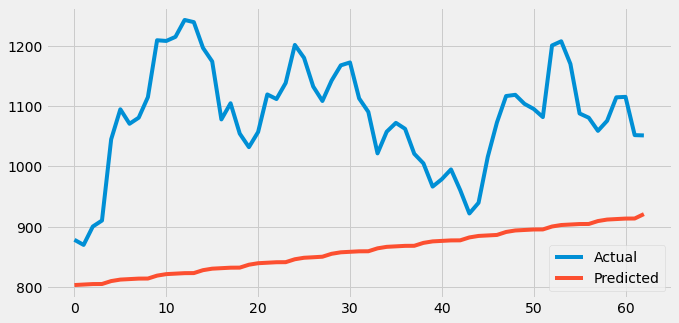

In [33]:
model = joblib.load(path+MODEL_NAME+".joblib")
plt.plot(test['y'].values, label='Actual')
plt.plot(test_pred['yhat'].values, label='Predicted')
plt.legend()
plt.show()

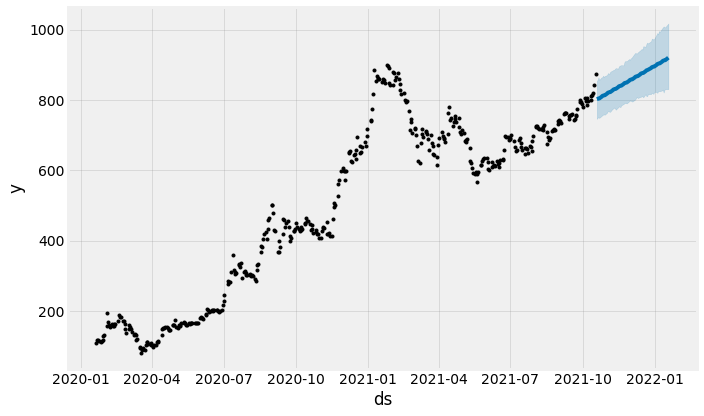

In [34]:
model.plot(test_pred)
plt.show()